# Modeling and Simulation in Python

Chapter 23

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

In [3]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree

<Unit('degree')>

In [4]:
params = Params(wall_height = 11.28 * m,
                x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s)

,values
wall_height,11.28 meter
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second


In [5]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [6]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

In [7]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    print(state)
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [8]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

### Optimal launch angle

To find the launch angle that maximizes distance from home plate, we need a function that takes launch angle and returns range.

In [9]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

Let's test `range_func`.

In [10]:
%time range_func(45, params)

[ 0.          1.         28.28427125 28.28427125]
[1.73143253e-05 1.00001731e+00 2.82842676e+01 2.82842616e+01]
[3.46286505e-04 1.00034629e+00 2.82841993e+01 2.82840793e+01]
[5.19428766e-04 1.00051943e+00 2.82841633e+01 2.82839833e+01]
[1.38513897e-03 1.00138513e+00 2.82839834e+01 2.82835035e+01]
[1.53904243e-03 1.00153903e+00 2.82839514e+01 2.82834181e+01]
[1.73142151e-03 1.00173140e+00 2.82839114e+01 2.82833115e+01]
[1.73142151e-03 1.00173140e+00 2.82839114e+01 2.82833115e+01]
[5.19424251e-03 1.00519415e+00 2.82831918e+01 2.82813921e+01]
[6.92555388e-03 1.00692526e+00 2.82828320e+01 2.82804324e+01]
[1.55820008e-02 1.01558051e+00 2.82810332e+01 2.82756344e+01]
[1.71208671e-02 1.01711907e+00 2.82807135e+01 2.82747814e+01]
[1.90444255e-02 1.01904220e+00 2.82803138e+01 2.82737153e+01]
[1.90444253e-02 1.01904220e+00 2.82803138e+01 2.82737153e+01]
[ 0.05366823  1.05365793 28.27311994 28.25452485]
[ 0.07097022  1.07093936 28.26952883 28.2449389 ]
[ 0.15746931  1.15731735 28.25157969 28.1970

<Quantity(102.72776151763686, 'meter')>

And sweep through a range of angles.

In [11]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    print(angle, x_dist)
    sweep[angle] = x_dist

[ 0.          1.         37.58770483 13.68080573]
[1.73141653e-05 1.00000630e+00 3.75877012e+01 1.36807999e+01]
[3.46283307e-04 1.00012604e+00 3.75876329e+01 1.36806893e+01]
[5.19424215e-04 1.00018905e+00 3.75875969e+01 1.36806310e+01]
[1.38512792e-03 1.00050414e+00 3.75874170e+01 1.36803398e+01]
[1.53903037e-03 1.00056015e+00 3.75873850e+01 1.36802881e+01]
[1.73140825e-03 1.00063017e+00 3.75873450e+01 1.36802233e+01]
[1.73140825e-03 1.00063017e+00 3.75873450e+01 1.36802233e+01]
[5.19420817e-03 1.00189049e+00 3.75866254e+01 1.36790586e+01]
[6.92553354e-03 1.00252052e+00 3.75862656e+01 1.36784762e+01]
[1.55820776e-02 1.00567057e+00 3.75844667e+01 1.36755645e+01]
[1.71209754e-02 1.00623051e+00 3.75841469e+01 1.36750469e+01]
[1.90445793e-02 1.00693040e+00 3.75837472e+01 1.36743999e+01]
[1.90445792e-02 1.00693040e+00 3.75837472e+01 1.36743999e+01]
[ 0.05366926  1.01952818 37.57655231 13.66275371]
[ 0.07097415  1.025815   37.57295861 13.65693391]
[ 0.15749035  1.05723574 37.5549942  13.6278

[ 0.          1.         33.92192385 21.19677057]
[1.73142962e-05 1.00001082e+00 3.39219202e+01 2.11967633e+01]
[3.46285924e-04 1.00021638e+00 3.39218519e+01 2.11966256e+01]
[5.19428059e-04 1.00032457e+00 3.39218159e+01 2.11965531e+01]
[1.38513782e-03 1.00086552e+00 3.39216360e+01 2.11961905e+01]
[1.53904129e-03 1.00096169e+00 3.39216040e+01 2.11961261e+01]
[1.73142044e-03 1.00108190e+00 3.39215640e+01 2.11960455e+01]
[1.73142044e-03 1.00108190e+00 3.39215640e+01 2.11960455e+01]
[5.19424294e-03 1.00324566e+00 3.39208444e+01 2.11945954e+01]
[6.92557154e-03 1.00432737e+00 3.39204846e+01 2.11938704e+01]
[1.55821228e-02 1.00973576e+00 3.39186857e+01 2.11902455e+01]
[1.71210173e-02 1.01069715e+00 3.39183660e+01 2.11896011e+01]
[1.90446148e-02 1.01189885e+00 3.39179663e+01 2.11887956e+01]
[1.90446147e-02 1.01189885e+00 3.39179663e+01 2.11887956e+01]
[ 0.05366917  1.03352906 33.91077173 21.174297  ]
[ 0.07097318  1.04432751 33.90717898 21.16705289]
[ 0.15748415  1.09830136 33.88922016 21.1308

[ 0.          1.         27.2799344  29.25414806]
[1.73143232e-05 1.00001857e+00 2.72799308e+01 2.92541380e+01]
[3.46286464e-04 1.00037135e+00 2.72798624e+01 2.92539465e+01]
[5.19428668e-04 1.00055702e+00 2.72798265e+01 2.92538457e+01]
[1.38513855e-03 1.00148537e+00 2.72796465e+01 2.92533418e+01]
[1.53904193e-03 1.00165040e+00 2.72796146e+01 2.92532522e+01]
[1.73142090e-03 1.00185670e+00 2.72795746e+01 2.92531402e+01]
[1.73142090e-03 1.00185670e+00 2.72795746e+01 2.92531402e+01]
[5.19423987e-03 1.00557004e+00 2.72788549e+01 2.92511245e+01]
[6.92554658e-03 1.00742642e+00 2.72784952e+01 2.92501167e+01]
[1.55819661e-02 1.01670801e+00 2.72766964e+01 2.92450781e+01]
[1.71208255e-02 1.01835791e+00 2.72763767e+01 2.92441824e+01]
[1.90443742e-02 1.02042020e+00 2.72759770e+01 2.92430628e+01]
[1.90443740e-02 1.02042020e+00 2.72759770e+01 2.92430628e+01]
[ 0.053668    1.05754081 27.26878327 29.22291033]
[ 0.07096954  1.07607233 27.2651925  29.21284433]
[ 0.15746595  1.16869821 27.24724538 29.1625

[ 0.          1.         18.77886251 35.31790371]
[1.73142406e-05 1.00003256e+00 1.87788589e+01 3.53178879e+01]
[3.46284813e-04 1.00065127e+00 1.87787905e+01 3.53175877e+01]
[5.19425726e-04 1.00097689e+00 1.87787546e+01 3.53174296e+01]
[1.38512864e-03 1.00260502e+00 1.87785747e+01 3.53166395e+01]
[1.53903051e-03 1.00289446e+00 1.87785427e+01 3.53164990e+01]
[1.73140748e-03 1.00325626e+00 1.87785027e+01 3.53163234e+01]
[1.73140748e-03 1.00325626e+00 1.87785027e+01 3.53163234e+01]
[5.19418925e-03 1.00976864e+00 1.87777831e+01 3.53131629e+01]
[6.92543085e-03 1.01302417e+00 1.87774233e+01 3.53115829e+01]
[1.55814733e-02 1.02930112e+00 1.87756248e+01 3.53036831e+01]
[1.71202388e-02 1.03219441e+00 1.87753052e+01 3.53022789e+01]
[1.90436583e-02 1.03581087e+00 1.87749056e+01 3.53005236e+01]
[1.90436579e-02 1.03581087e+00 1.87749056e+01 3.53005236e+01]
[ 0.05366484  1.10090552 18.7677135  35.26892976]
[ 0.07096051  1.13338731 18.76412688 35.25315832]
[ 0.15742261  1.29572424 18.74620407 35.1743

[ 0.          1.         11.02549423 38.45046784]
[1.73139632e-05 1.00006038e+00 1.10254906e+01 3.84504399e+01]
[3.46279264e-04 1.00120762e+00 1.10254223e+01 3.84499091e+01]
[5.19416353e-04 1.00181141e+00 1.10253863e+01 3.84496297e+01]
[1.38509898e-03 1.00483034e+00 1.10252064e+01 3.84482328e+01]
[1.53899663e-03 1.00536702e+00 1.10251744e+01 3.84479845e+01]
[1.73136807e-03 1.00603788e+00 1.10251344e+01 3.84476741e+01]
[1.73136807e-03 1.00603788e+00 1.10251344e+01 3.84476741e+01]
[5.19404770e-03 1.01811319e+00 1.10244148e+01 3.84420868e+01]
[6.92513327e-03 1.02414888e+00 1.10240552e+01 3.84392940e+01]
[1.55802795e-02 1.05432511e+00 1.10222573e+01 3.84253306e+01]
[1.71188252e-02 1.05968863e+00 1.10219377e+01 3.84228487e+01]
[1.90419434e-02 1.06639253e+00 1.10215383e+01 3.84197466e+01]
[1.90419422e-02 1.06639252e+00 1.10215383e+01 3.84197466e+01]
[ 0.05365744  1.18705797 11.01434984 38.36390934]
[ 0.0709398   1.2471934  11.01077212 38.33607089]
[ 0.15732426  1.54765583 10.99290133 38.1969

Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

Saving figure to file figs/chap10-fig03.pdf


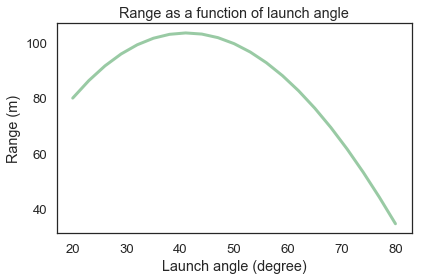

In [12]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/chap10-fig03.pdf')

We can use `max_bounded` to search for the peak efficiently.

In [13]:
%time res = max_bounded(range_func, [0, 90], params)

[ 0.          1.         33.01363222 22.58539546]
[1.73143076e-05 1.00001185e+00 3.30136286e+01 2.25853879e+01]
[3.46286152e-04 1.00023690e+00 3.30135602e+01 2.25852434e+01]
[5.19428378e-04 1.00035535e+00 3.30135243e+01 2.25851674e+01]
[1.38513857e-03 1.00094760e+00 3.30133443e+01 2.25847873e+01]
[1.53904211e-03 1.00105288e+00 3.30133124e+01 2.25847198e+01]
[1.73142132e-03 1.00118449e+00 3.30132724e+01 2.25846353e+01]
[1.73142132e-03 1.00118449e+00 3.30132724e+01 2.25846353e+01]
[5.19424509e-03 1.00355344e+00 3.30125527e+01 2.25831151e+01]
[6.92557206e-03 1.00473773e+00 3.30121930e+01 2.25823550e+01]
[1.55821126e-02 1.01065899e+00 3.30103941e+01 2.25785547e+01]
[1.71210039e-02 1.01171156e+00 3.30100743e+01 2.25778791e+01]
[1.90445968e-02 1.01302722e+00 3.30096746e+01 2.25770347e+01]
[1.90445967e-02 1.01302722e+00 3.30096746e+01 2.25770347e+01]
[ 0.05366906  1.03670869 33.00248022 22.56183461]
[ 0.0709728   1.04853149 32.9988877  22.55424032]
[ 0.15748217  1.10762567 32.98093031 22.5162

[ 0.19206189  1.1675782  30.08469609 26.21828782]
[ 0.19206175  1.16757799 30.08469616 26.2182879 ]
[ 0.53788994  1.46896123 30.01299296 26.04314731]
[ 0.70987677  1.61738792 29.97767449 25.9563424 ]
[ 1.56888956  2.35716122 29.80161144 25.52308569]
[ 1.72117399  2.48751745 29.77056604 25.44644209]
[ 1.91116075  2.64970283 29.73195514 25.35089654]
[ 1.91101214  2.64948974 29.73202547 25.35097535]
[ 5.32875406  5.56362323 29.03819833 23.63285946]
[ 6.94789896  6.79850241 28.74135901 22.84483598]
[15.04625873 12.87118806 27.25646199 18.91155033]
[16.54586525 13.97924131 26.96759041 18.19123127]
[18.25687267 15.10944295 26.68257077 17.37747814]
[18.10029284 14.88997449 26.75451234 17.45710482]
[27.85524475 21.2550024  25.13537636 12.82745754]
[32.06857413 22.53850081 24.63568069 10.9297158 ]
[54.4058568  29.54947896 21.56004366  0.87925665]
[60.49435963 32.94728202 20.26224519 -1.61733076]
[64.82670978 32.62318498 19.81396933 -3.545136  ]
[61.1331805  27.88966482 21.08546391 -2.27253777]


`res` is an `ModSimSeries` object with detailed results:

In [14]:
res

,values
fun,103.46837822354611 meter
status,0
success,True
message,Solution found.
x,41.1391
nfev,9


`x` is the optimal angle and `fun` the optional range.

In [15]:
optimal_angle = res.x * degree

<Quantity(41.139142795614596, 'degree')>

In [16]:
max_x_dist = res.fun

<Quantity(103.46837822354611, 'meter')>

### Under the hood

Read the source code for `max_bounded` and `min_bounded`, below.

Add a print statement to `range_func` that prints `angle`.  Then run `max_bounded` again so you can see how many times it calls `range_func` and what the arguments are.

In [17]:
%psource max_bounded

In [18]:
%psource min_bounded

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a params as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [19]:
def event_func_wall(state, t, system):
    x, y, vx, vy = state
    return 94.5 - x

def height_func(angle, params):  
    """Computes height for a given launch velocity.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: height in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func_wall)
    height = get_last_value(results.y) * m
    return height


Always test the height function with the initial conditions.

In [20]:
slope_func(params, 0, make_system(params))

wall_height                  11.28 meter
x                                0 meter
y                                1 meter
g                9.8 meter / second ** 2
mass                      0.145 kilogram
diameter                     0.073 meter
rho            1.2 kilogram / meter ** 3
C_d                                  0.3
angle                          45 degree
velocity             40.0 meter / second
t_end                          20 second
dtype: object


ValueError: too many values to unpack (expected 4)

In [21]:
res = max_bounded(height_func, [0, 90], params)

[ 0.          1.         33.01363222 22.58539546]
[1.73143076e-05 1.00001185e+00 3.30136286e+01 2.25853879e+01]
[3.46286152e-04 1.00023690e+00 3.30135602e+01 2.25852434e+01]
[5.19428378e-04 1.00035535e+00 3.30135243e+01 2.25851674e+01]
[1.38513857e-03 1.00094760e+00 3.30133443e+01 2.25847873e+01]
[1.53904211e-03 1.00105288e+00 3.30133124e+01 2.25847198e+01]
[1.73142132e-03 1.00118449e+00 3.30132724e+01 2.25846353e+01]
[1.73142132e-03 1.00118449e+00 3.30132724e+01 2.25846353e+01]
[5.19424509e-03 1.00355344e+00 3.30125527e+01 2.25831151e+01]
[6.92557206e-03 1.00473773e+00 3.30121930e+01 2.25823550e+01]
[1.55821126e-02 1.01065899e+00 3.30103941e+01 2.25785547e+01]
[1.71210039e-02 1.01171156e+00 3.30100743e+01 2.25778791e+01]
[1.90445968e-02 1.01302722e+00 3.30096746e+01 2.25770347e+01]
[1.90445967e-02 1.01302722e+00 3.30096746e+01 2.25770347e+01]
[ 0.05366906  1.03670869 33.00248022 22.56183461]
[ 0.0709728   1.04853149 32.9988877  22.55424032]
[ 0.15748217  1.10762567 32.98093031 22.5162

[61.056555   31.82462996 20.58201295 -1.85779034]
[65.44270612 31.44948923 20.11949263 -3.77400289]
[61.72314805 26.79622602 21.40642764 -2.52260372]
[73.59951569 25.39667586 20.07639371 -7.8029455 ]
[ 78.70755312  21.40115282  19.50532852 -10.07440805]
[104.2520186    1.39823182  16.2286294  -21.21433806]
[109.66428161  -0.27097769  15.23607163 -23.52596236]
[114.50888984  -7.70525115  14.50244617 -25.47171296]
[112.39478235 -12.92357747  15.14231158 -24.54233284]
[ 0.          1.         29.73110726 26.75932102]
[1.73143252e-05 1.00001558e+00 2.97311037e+01 2.67593121e+01]
[3.46286504e-04 1.00031167e+00 2.97310353e+01 2.67591421e+01]
[5.19428813e-04 1.00046751e+00 2.97309993e+01 2.67590526e+01]
[1.38513931e-03 1.00124668e+00 2.97308194e+01 2.67586054e+01]
[1.53904285e-03 1.00138519e+00 2.97307874e+01 2.67585258e+01]
[1.73142204e-03 1.00155834e+00 2.97307474e+01 2.67584264e+01]
[1.73142204e-03 1.00155834e+00 2.97307474e+01 2.67584264e+01]
[5.19424517e-03 1.00467497e+00 2.97300278e+01 

[1.73142162e-03 1.00170386e+00 2.85097761e+01 2.80556391e+01]
[5.19424301e-03 1.00511152e+00 2.85090564e+01 2.80537406e+01]
[6.92555537e-03 1.00681509e+00 2.85086967e+01 2.80527914e+01]
[1.55820080e-02 1.01533266e+00 2.85068979e+01 2.80480457e+01]
[1.71208759e-02 1.01684674e+00 2.85065781e+01 2.80472021e+01]
[1.90444363e-02 1.01873929e+00 2.85061785e+01 2.80461476e+01]
[1.90444361e-02 1.01873929e+00 2.85061785e+01 2.80461476e+01]
[ 0.05366828  1.05280437 28.49898456 28.02716663]
[ 0.07097037  1.06981098 28.49539338 28.01768519]
[ 0.15747004  1.15481539 28.4774438  27.97028799]
[ 0.17284216  1.1699124  28.47425606 27.961867  ]
[ 0.19205473  1.18877701 28.47027288 27.9513431 ]
[ 0.19205456  1.18877674 28.47027296 27.9513432 ]
[ 0.5378569   1.52827611 28.39858984 27.76193502]
[ 0.70977856  1.69543765 28.3633218  27.66812962]
[ 1.56842238  2.52856372 28.18754709 27.19999756]
[ 1.72062599  2.67536623 28.15656856 27.11721437]
[ 1.91047963  2.8579812  28.11806051 27.01404588]
[ 1.91031056  2.

,values
fun,11.04782805563812 meter
status,0
success,True
message,Solution found.
x,44.5406
nfev,12


Test your function with a launch angle of 45 degrees:

In [ ]:
height_func(45 * degree, params)

Now use `max_bounded` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [24]:
res = max_bounded(height_func, [0, 90], params);

[ 0.          1.         33.01363222 22.58539546]
[1.73143076e-05 1.00001185e+00 3.30136286e+01 2.25853879e+01]
[3.46286152e-04 1.00023690e+00 3.30135602e+01 2.25852434e+01]
[5.19428378e-04 1.00035535e+00 3.30135243e+01 2.25851674e+01]
[1.38513857e-03 1.00094760e+00 3.30133443e+01 2.25847873e+01]
[1.53904211e-03 1.00105288e+00 3.30133124e+01 2.25847198e+01]
[1.73142132e-03 1.00118449e+00 3.30132724e+01 2.25846353e+01]
[1.73142132e-03 1.00118449e+00 3.30132724e+01 2.25846353e+01]
[5.19424509e-03 1.00355344e+00 3.30125527e+01 2.25831151e+01]
[6.92557206e-03 1.00473773e+00 3.30121930e+01 2.25823550e+01]
[1.55821126e-02 1.01065899e+00 3.30103941e+01 2.25785547e+01]
[1.71210039e-02 1.01171156e+00 3.30100743e+01 2.25778791e+01]
[1.90445968e-02 1.01302722e+00 3.30096746e+01 2.25770347e+01]
[1.90445967e-02 1.01302722e+00 3.30096746e+01 2.25770347e+01]
[ 0.05366906  1.03670869 33.00248022 22.56183461]
[ 0.0709728   1.04853149 32.9988877  22.55424032]
[ 0.15748217  1.10762567 32.98093031 22.5162

[5.19428813e-04 1.00046751e+00 2.97309993e+01 2.67590526e+01]
[1.38513931e-03 1.00124668e+00 2.97308194e+01 2.67586054e+01]
[1.53904285e-03 1.00138519e+00 2.97307874e+01 2.67585258e+01]
[1.73142204e-03 1.00155834e+00 2.97307474e+01 2.67584264e+01]
[1.73142204e-03 1.00155834e+00 2.97307474e+01 2.67584264e+01]
[5.19424517e-03 1.00467497e+00 2.97300278e+01 2.67566373e+01]
[6.92556244e-03 1.00623305e+00 2.97296680e+01 2.67557428e+01]
[1.55820441e-02 1.01402319e+00 2.97278692e+01 2.67512705e+01]
[1.71209195e-02 1.01540797e+00 2.97275495e+01 2.67504754e+01]
[1.90444902e-02 1.01713888e+00 2.97271498e+01 2.67494817e+01]
[1.90444901e-02 1.01713888e+00 2.97271498e+01 2.67494817e+01]
[ 0.05366853  1.04829475 29.71995572 26.73159386]
[ 0.07097113  1.06384924 29.71636415 26.72265798]
[ 0.15747373  1.14159584 29.69841229 26.67798742]
[ 0.17284661  1.15540399 29.69522397 26.67005058]
[ 0.19206023  1.17265818 29.69123998 26.66013159]
[ 0.19206007  1.17265796 29.69124005 26.66013167]
[ 0.53788223  1.48

[18.22471796 16.89059224 25.10031255 18.44698884]
[18.04611534 16.61753402 25.18256479 18.54746617]
[27.32857615 23.45425337 23.67418601 13.82416966]
[31.34430831 24.91394473 23.21856936 11.89579515]
[52.68452033 32.87534933 20.38690562  1.64906609]
[58.55203534 36.58231578 19.16552166 -0.9236664 ]
[62.69835964 36.40689772 18.76422885 -2.88861806]
[59.10400795 31.41276833 19.97833766 -1.55180058]
[70.5203541  30.52601324 18.78974579 -7.05955285]
[75.46442215 26.54189029 18.2728913  -9.44399732]
[100.12247413   6.44012103  15.23108513 -21.10080643]
[105.30267511   4.69300719  14.25707386 -23.51456754]
[110.01481986  -2.95367919  13.55211386 -25.54000539]
[108.03152143  -8.26067499  14.21388797 -24.56662471]
[ 0.          1.         28.5101359  28.05658837]
[1.73143255e-05 1.00001704e+00 2.85101323e+01 2.80565789e+01]
[3.46286510e-04 1.00034078e+00 2.85100639e+01 2.80563985e+01]
[5.19428781e-04 1.00051116e+00 2.85100280e+01 2.80563036e+01]
[1.38513905e-03 1.00136309e+00 2.85098480e+01 2.

,values
fun,11.04782805563812 meter
status,0
success,True
message,Solution found.
x,44.5406
nfev,12


In [25]:
res

,values
fun,11.04782805563812 meter
status,0
success,True
message,Solution found.
x,44.5406
nfev,12


In [26]:
# Solution goes here

With initial velocity 40 m/s and an optimal launch angle, the ball clears the Green Monster with a little room to spare.

Which means we can get over the wall with a lower initial velocity.

### Finding the minimum velocity

Even though we are finding the "minimum" velocity, we are not really solving a minimization problem.  Rather, we want to find the velocity that makes the height at the wall exactly 11 m, given given that it's launched at the optimal angle.  And that's a job for `fsolve`.

Write an error function that takes a velocity and a `Params` object as parameters.  It should use `max_bounded` to find the highest possible height of the ball at the wall, for the given velocity.  Then it should return the difference between that optimal height and 11 meters.

In [27]:
# Solution goes here

Test your error function before you call `fsolve`.

In [28]:
# Solution goes here

Then use `fsolve` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [29]:
# Solution goes here

In [30]:
# Solution goes here

And just to check, run `error_func` with the value you found.

In [29]:
# Solution goes here